In [ ]:
# Importing the Modules
from scripts.analysis import  plot_selection, nclones_report, scatter_colored
from scripts.helpers import list_datasets
import pandas as pd

In [ ]:
# Listing the existing datasets in the output folder
datasets_input = list_datasets()

In [ ]:
# Change the plot_all variable to True in order fo process all of the datasets
for dataset in [datasets_input[0]]:
    plot_selection(dataset_path=dataset,
                   save_fig=False,
                   xjitter = True)

In [ ]:
# Plotting the data
scatter_colored(df_path = datasets_input[1],
                group_by = "ab_target",
                color_by = "time_point",
                ylim = (-1,0.6),
                save_fig = True,
                map_cols = {"ab_target":{"sn":"Spike Positive", "sp": "Spike Negative"},
                           "time_point":{1:"pre", 2: "2 weeks", 4:"3 weeks"}}
                           )

In [ ]:
# Report of the number of unique clones and sequences for each sub-group
if False:
    # Initiating the report object
    raw_dataset_name = "cl_seqs_motif.csv"
    clones = nclones_report(dataset_name = raw_dataset_name)

    # Creating a report that contains number of unique clones and sequence count per sub-dataset.
    clones_report = clones.groupby_count(groupby_list = ["subject_id", "ab_target"]) 

    # Listing the number of unique clones and sequence count per sub-dataset
    print(clones_report)

----
Custom function for last graphs (for supp. material - article)

In [17]:
# Importing modules
import os
import pandas as pd

# Getting information about the datasets
path_input= os.path.join("output", "r_data")
path_new = os.path.join("output", "new")
data_files = os.listdir(path_input)

# Creating orginized lists of files
data_all = data_files[1:4]
data_motif = data_files[4:]

list_df_all = []
list_df_motif = []

for i in [os.path.join(path_input, i) for i in data_all]:
    print(i)
    temp_df = pd.read_csv(i, index_col=0)
    temp_df["time_point"] = i.split("_")[2][-1]
    list_df_all.append(temp_df)

for i in [os.path.join(path_input, i) for i in data_motif]:
    temp_df = pd.read_csv(i, index_col=0)
    temp_df["time_point"] = i.split("_")[2][-1]
    list_df_motif.append(temp_df)

concat_all = pd.concat(list_df_all)
concat_motif = pd.concat(list_df_motif)

list_newdata = []
for i in [(concat_all, "allseq"), (concat_motif, "motif")]:
    temp_df = i[0]

    for j in [f"subj_{k}" for k in range(3,8)]:
        name = f"{i[1]}_{j}.csv"
        path = os.path.join("output", "new", name)
        temp_subj = temp_df[temp_df.subject_id == j]
        temp_subj.to_csv(path)
        list_newdata.append(path)

output\r_data\all_tp1_[2025-11-27_18-49-50]_baseline_values.csv
output\r_data\all_tp2_[2025-11-27_18-49-50]_baseline_values.csv
output\r_data\all_tp4_[2025-11-27_18-49-50]_baseline_values.csv


Plot saves as allseq_subj_3


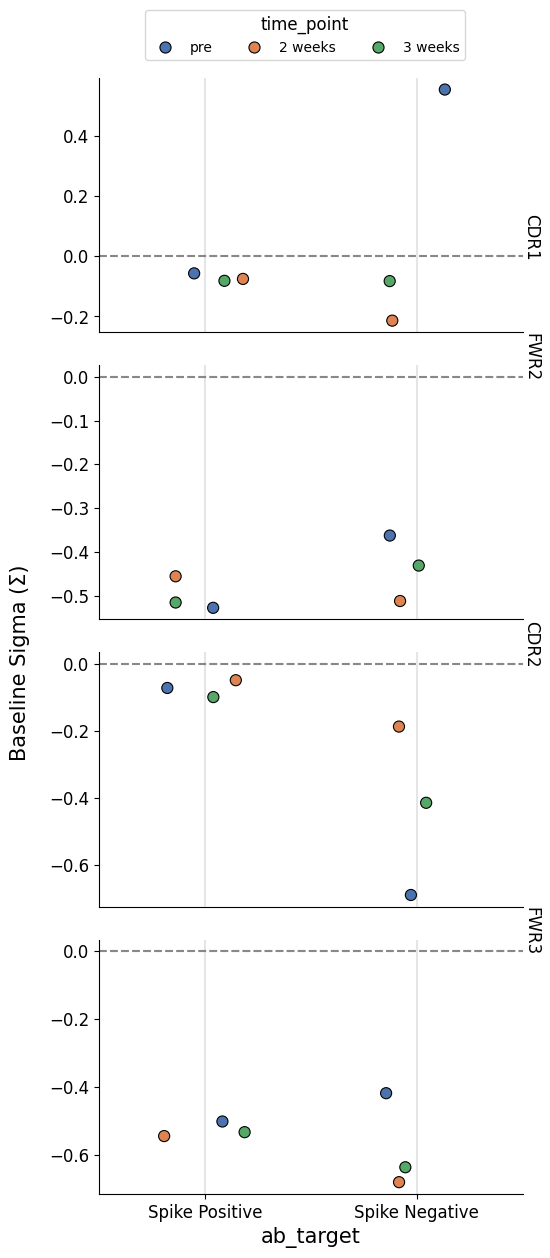

Plot saves as allseq_subj_4


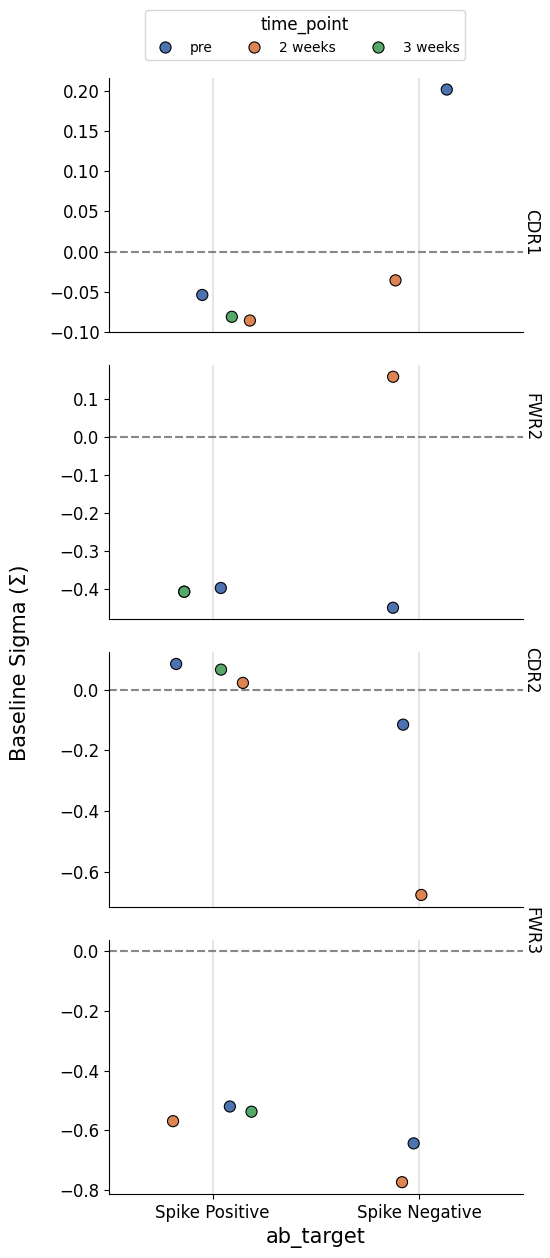

Plot saves as allseq_subj_5


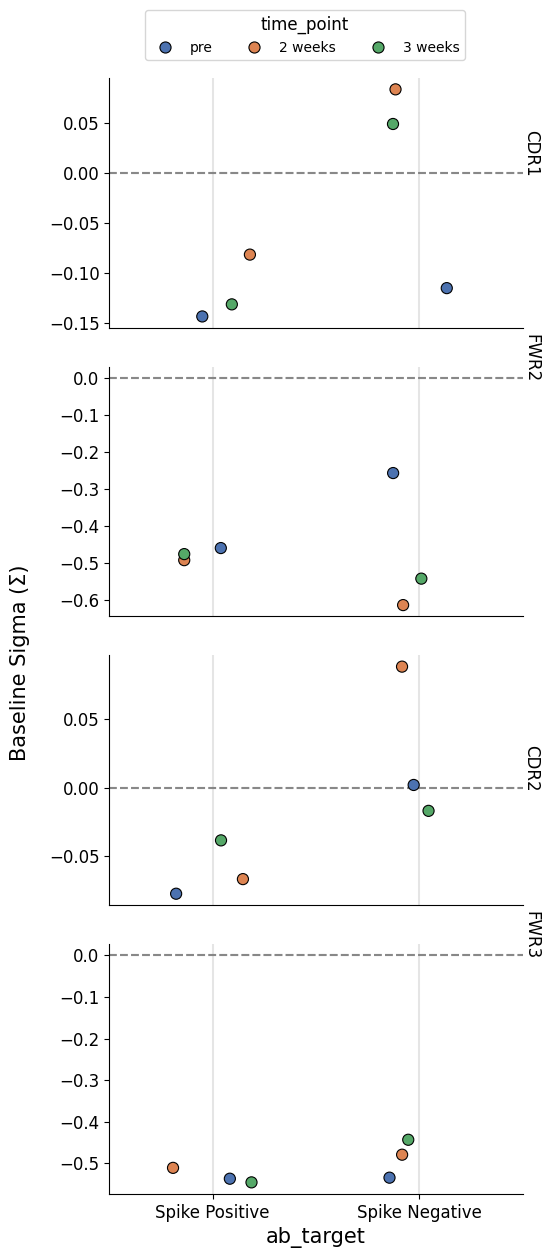

Plot saves as allseq_subj_6


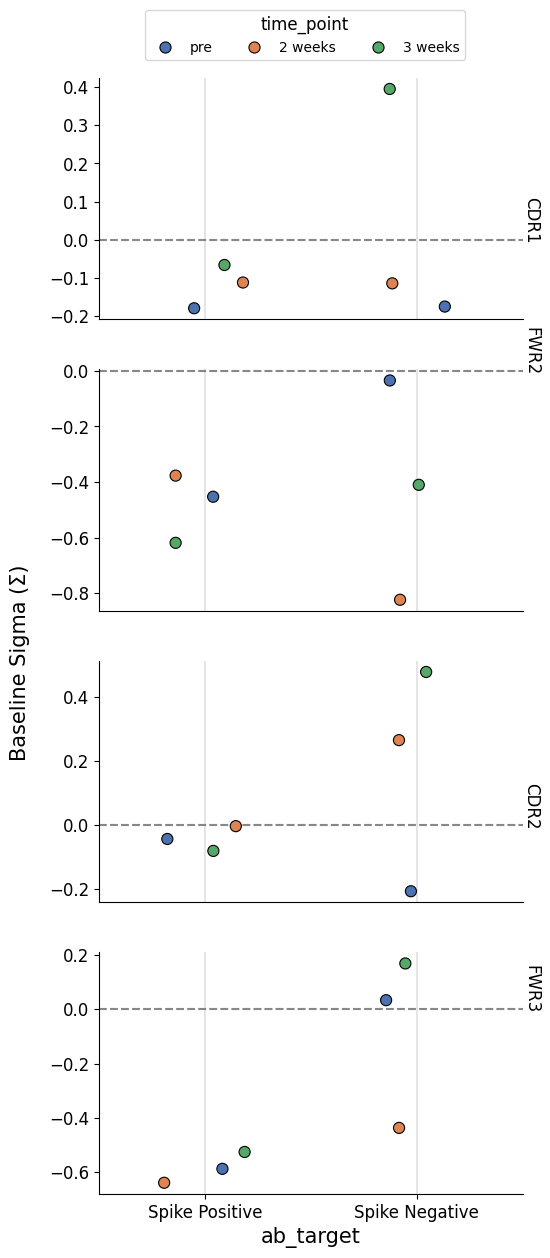

Plot saves as allseq_subj_7


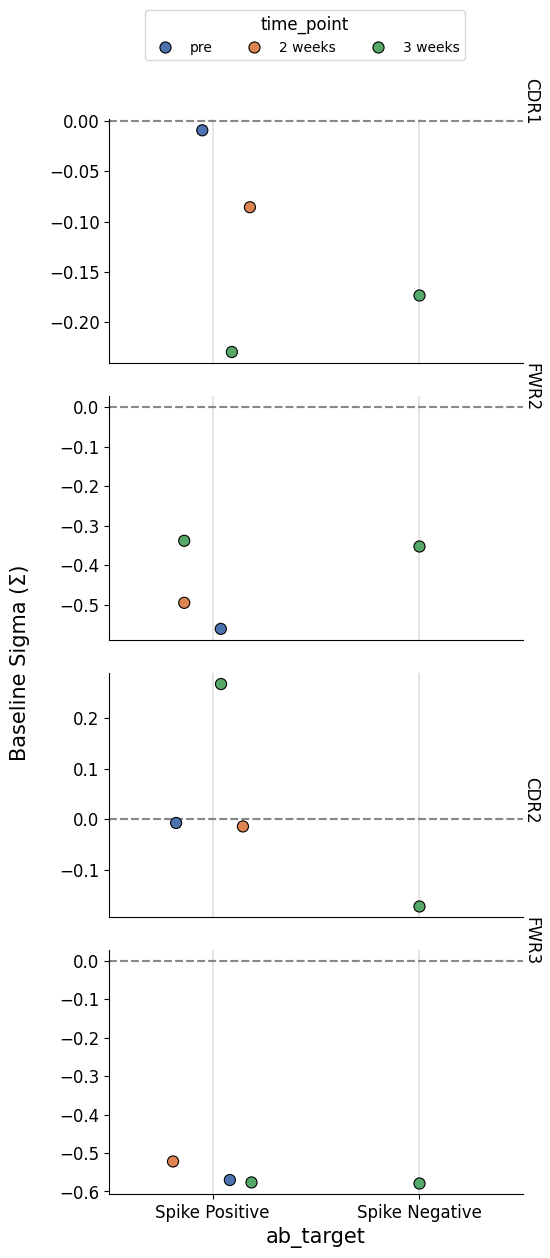

Plot saves as motif_subj_3


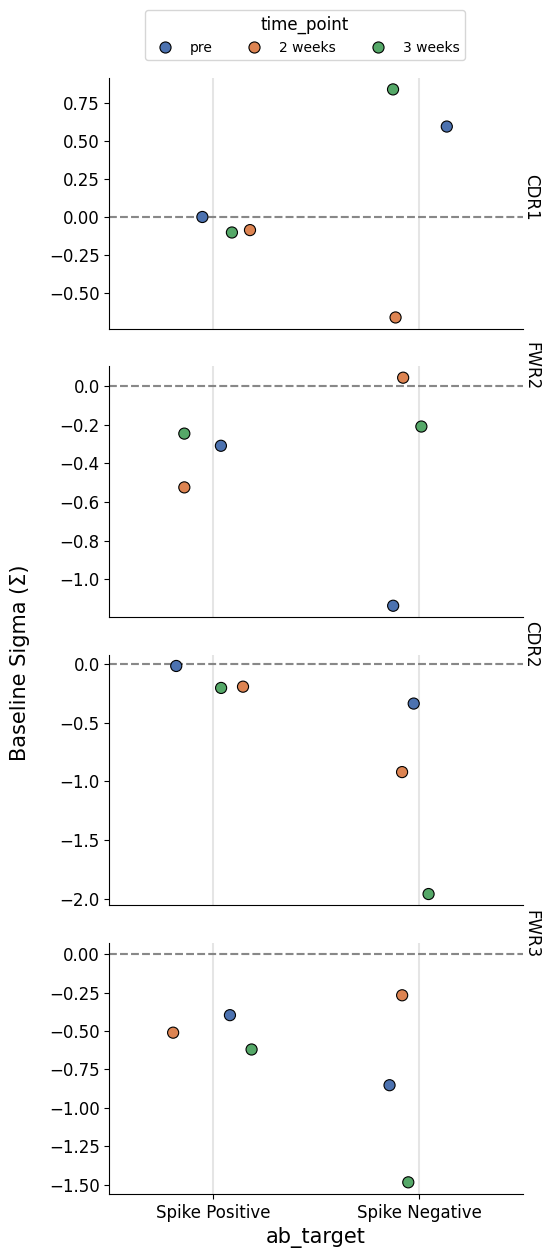

Plot saves as motif_subj_4


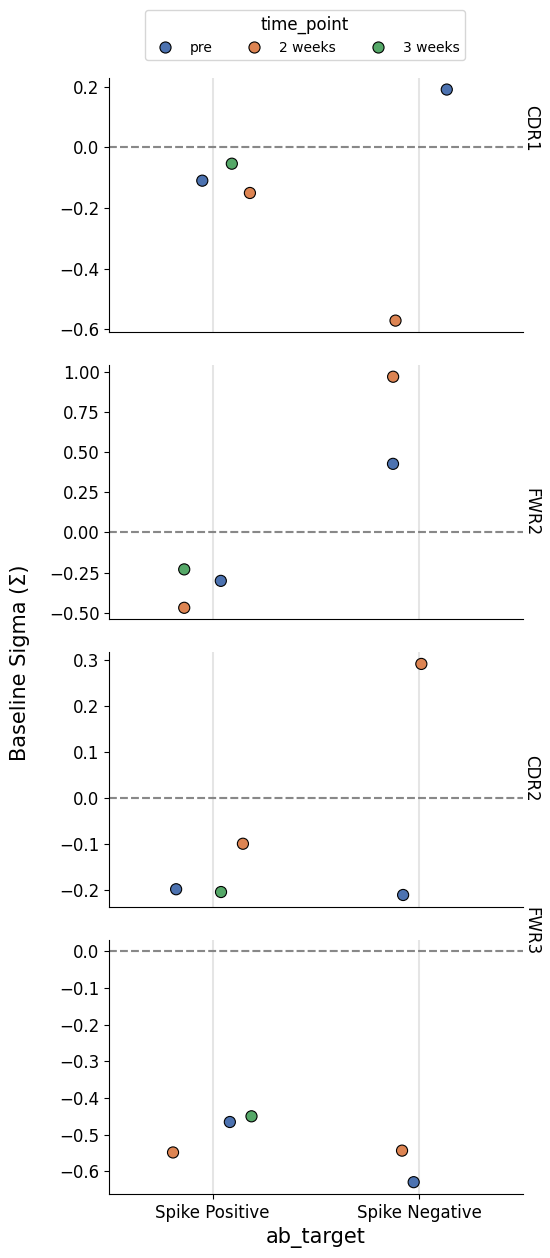

Plot saves as motif_subj_5


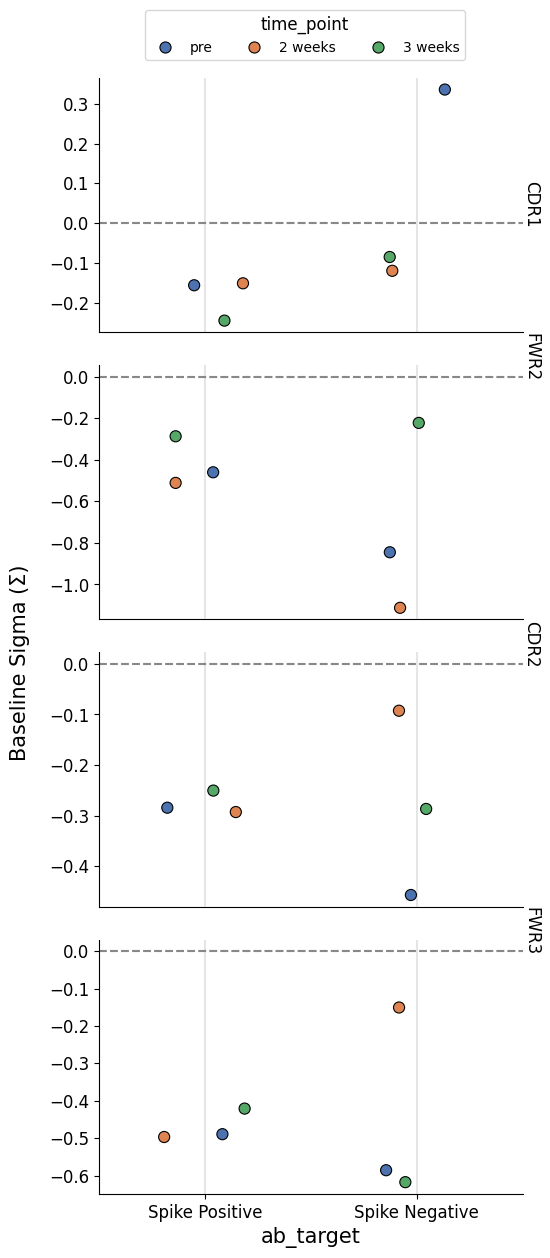

Plot saves as motif_subj_6


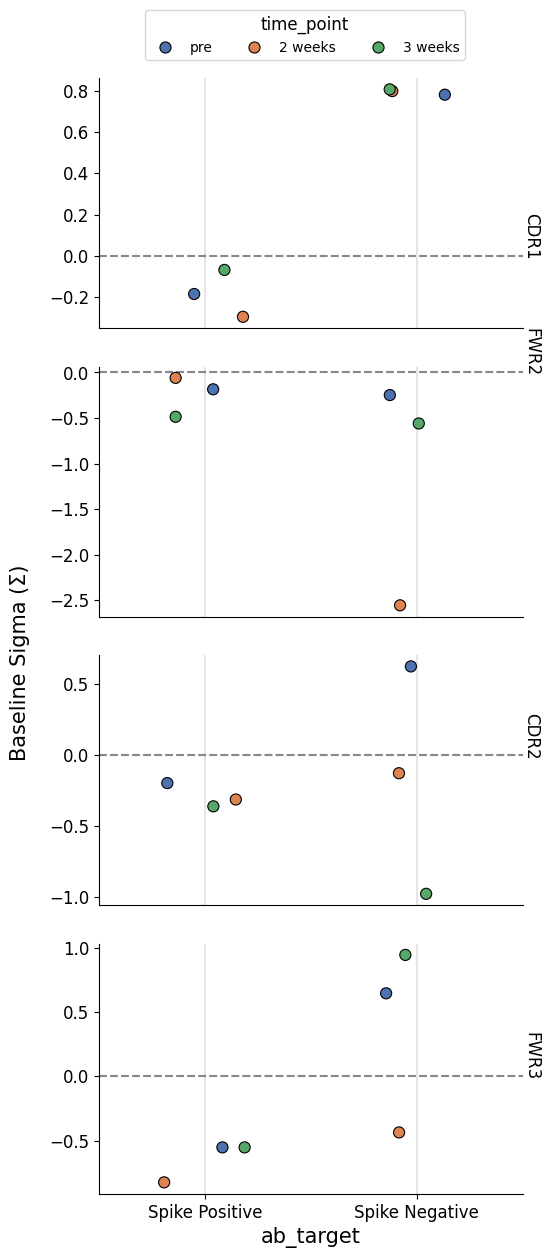

Plot saves as motif_subj_7


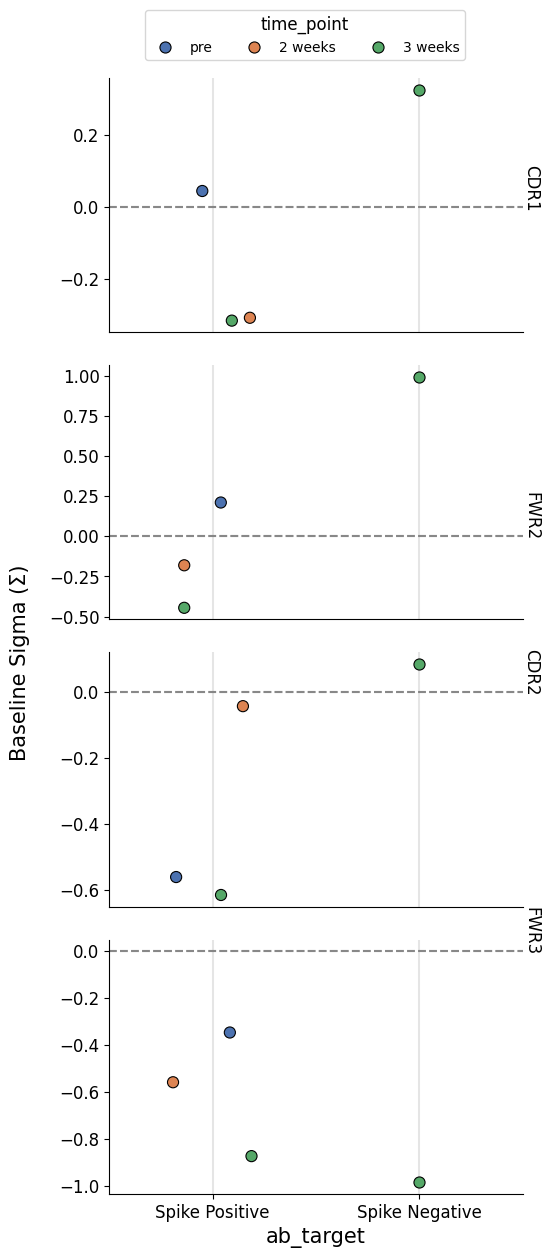

In [21]:
from scripts.analysis import  scatter_colored

save_path = os.path.join("output", "py_figures")

for i in list_newdata:
    scatter_colored(df_path = i,
                    group_by = "ab_target",
                    color_by = "time_point",
                    save_fig = True,
                    fig_name = i.split("\\")[-1].split(".")[0],
                    map_cols = {"ab_target":{"sn":"Spike Positive", "sp": "Spike Negative"},
                            "time_point":{1:"pre", 2: "2 weeks", 4:"3 weeks"}}
                            )

        